In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

Import needed libraries

In [2]:
# Generate data
def generate_data(num_samples=100, noise=0.01):
    #  generating function: y_n = 2x_n + cos(25x_n) + N (0, 1), where N is a Gaussian distributio
    x = torch.linspace(-1, 1, num_samples).unsqueeze(1)
    N = noise*torch.randn_like(x)
    y = 2*x + torch.cos(25*x) + N
    return x, y


# Split data into training and testing sets
num_train = 20
num_test = 100

x_train, y_train = generate_data(num_train)
x_test, y_test = generate_data(num_test)

generate training and testing data sets from the generating function $y_n=2x_n+\cos(25x_n)+N(0,1)$ where N is the gausian distribution `torch.randn_like(x)`


In [3]:
# create random Fourier features
def create_random_fourier_features(x, degree):
    # Create random Fourier features
    # random Fourier feature (RFF) model, where the basis function ϕ : x_n → cos(2πω_ix_n). 
    # Here, ω_i is sampled from the Gaussian N (0, 1) and i ∈ [1, 2, 3,..., p].
    # print('x', x.size())
    w = torch.randn(degree, 1) * 20 # vector of random weights (p x 1) sampled from N(0,1)
    phi = torch.cos(2*torch.pi*torch.mm(w, x.T)) # random features (n x p)
    # if degree == 3:
    #     plt.plot(x, phi.T)
    #     plt.title('Random Fourier Features at degree {}'.format(degree))
    #     plt.show()
    return phi.T

# Solve using Moore-Penrose pseudoinverse with regularization
def solve_with_regularized_pseudoinverse(x_train_rff, y_train, x_test_rff, y_test, lambda_reg=1e-12):
    # Compute regularized pseudoinverse
    I = torch.eye(x_train_rff.size(1))
    gram_matrix = x_train_rff.T @ x_train_rff + lambda_reg * I

    # Check conditioning of the gram matrix

    condition_number = torch.linalg.cond(gram_matrix)
    if condition_number > 1e10:
        print(f"Warning: Ill-conditioned matrix at degree {x_train_rff.size(1) - 1}, condition number: {condition_number}")

    pseudoinverse = torch.linalg.pinv(gram_matrix) @ x_train_rff.T
    weights = pseudoinverse @ y_train
    # print('weights', weights.size())

    # Compute predictions
    y_train_pred = x_train_rff @ weights
    y_test_pred = x_test_rff @ weights

    # Compute errors
    train_error = ((y_train - y_train_pred)**2).mean().item()
    test_error = ((y_test - y_test_pred)**2).mean().item()

    return train_error, test_error


Then we make our Random Fourier Feature (RFF) model with the basis functions given by $\cos(2\pi\omega_ix_n)$ where $\omega_i$ is also sanpled from the Gaussian Distribution. We then solve this model using the Regularized Pseudoinverse function found in the linear_models_bias_variance colab 

In [4]:
# Train and evaluate models with varying degrees
def train_and_evaluate(max_degree, lambda_reg=1e-2):
    train_errors = []
    test_errors = []
    param_counts = []

    for degree in range(1, max_degree + 1, 1):
        print(f"Training model with Random Fourier Features degree {degree}...")

        # Prepare data with Legendre polynomial features
        # print('x_train', x_train.size())
        x_train_poly = create_random_fourier_features(x_train, degree)
        # print('x_train_poly', x_train_poly.size())
        # print('x_test', y_train.size())
        x_test_poly = create_random_fourier_features(x_test, degree)
        

        train_error, test_error = solve_with_regularized_pseudoinverse(
                x_train_poly, y_train, x_test_poly, y_test, lambda_reg=lambda_reg
        )
        # Store errors and parameter counts
        train_errors.append(train_error)
        test_errors.append(test_error)
        param_counts.append((degree + 1))  # Number of parameters = degree + 1

        print(f"Degree {degree} completed. Train Error: {train_error:.6f}, Test Error: {test_error:.6f}\n")

    return param_counts, train_errors, test_errors

now we iterate through each degree to to generate training and testing sets and solving them with the regularized psuedoinverse

Training model with Random Fourier Features degree 1...
Degree 1 completed. Train Error: 1.980057, Test Error: 5.576274

Training model with Random Fourier Features degree 2...
Degree 2 completed. Train Error: 2.000684, Test Error: 1.890980

Training model with Random Fourier Features degree 3...
Degree 3 completed. Train Error: 1.997739, Test Error: 1.907450

Training model with Random Fourier Features degree 4...
Degree 4 completed. Train Error: 1.994866, Test Error: 1.897685

Training model with Random Fourier Features degree 5...
Degree 5 completed. Train Error: 1.482525, Test Error: 6.219657

Training model with Random Fourier Features degree 6...
Degree 6 completed. Train Error: 1.714273, Test Error: 2.189224

Training model with Random Fourier Features degree 7...
Degree 7 completed. Train Error: 1.948289, Test Error: 11.989459

Training model with Random Fourier Features degree 8...
Degree 8 completed. Train Error: 1.479652, Test Error: 2.678691

Training model with Random Four

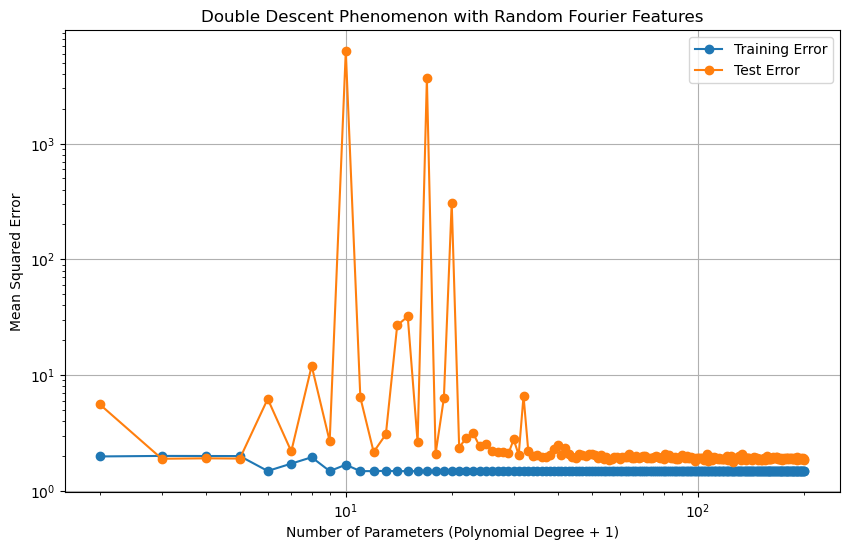

In [5]:
# Perform experiment
max_degree = 200 # Extend degree range to observe double descent
lambda_reg = 0  # Regularization strength
param_counts, train_errors, test_errors = train_and_evaluate(max_degree, lambda_reg=lambda_reg)

# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(param_counts, train_errors, label="Training Error", marker='o')
plt.loglog(param_counts, test_errors, label="Test Error", marker='o')
# plt.ylim([1e-3,100])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Polynomial Degree + 1)")
plt.ylabel("Mean Squared Error")
plt.title("Double Descent Phenomenon with Random Fourier Features")
plt.legend()
plt.grid(True)
plt.show()

Finally we run our model across 200 degrees and no stabilization to ensure we can see double descent and we plot our results in matplotlib

The Graph seems to show double or even more descents, however I was not able to get the training error very close to 0 since it flattend out around 1.5, the testing error however goes through it's descents before stablizing and trending towards the training error.